In [1]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import display, Image
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7bb3d33d3620>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7bb3d33d3830>, model_name='qwen-2.5-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
## define tools and bind with llm
def add(a:int,b:int)->int:
    """
    add a to b
    """
    return a+b

def multiply(a:int,b:int)->int:
    """
    Multiply a to b
    """
    return a*b
tools=[add, multiply]
llm_with_tools=llm.bind_tools(tools)

In [9]:
sys_msg=SystemMessage(content='You are a helpfull assistant tasked with preforming arthmetic on a set of inputs.')

def assistant(state:MessagesState):
    return {'messages':[llm_with_tools.invoke([sys_msg]+state['messages'])]}

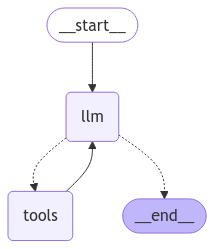

In [11]:
## Graph
builder2=StateGraph(MessagesState)
builder2.add_node("llm",assistant)
builder2.add_node("tools",ToolNode(tools))
builder2.add_edge(START,"llm")
builder2.add_conditional_edges(
    "llm",
    ## If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    ## IF the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder2.add_edge("tools","llm")
tool_graph1=builder2.compile()

## display
display(Image(tool_graph1.get_graph().draw_mermaid_png()))

In [12]:
messages=tool_graph1.invoke({"messages":HumanMessage(content="what is 2*3 and then add 4 and then multiply by 10?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2*3 and then add 4 and then multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8zrt)
 Call ID: call_8zrt
  Args:
    a: 2
    b: 3
  add (call_w341)
 Call ID: call_w341
  Args:
    a: 6
    b: 4
  multiply (call_3zw6)
 Call ID: call_3zw6
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The result of 2*3 is 6. When you add 4 to that, you get 10. And when you multiply that result by 10, you end up with 100.


In [13]:
messages=tool_graph1.invoke({"messages":HumanMessage(content="and multiply that by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

and multiply that by 10
================================== Ai Message ==================================

It looks like you want to multiply a number by 10, but you haven't provided the initial number. Could you please specify the number you want to multiply by 10?


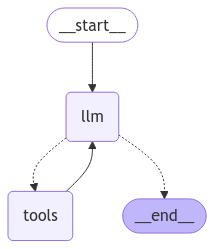

In [42]:
## Memory in Agents using MemorySaver
memory=MemorySaver()
config={'configurable':{'thread_id':'1'}}

## Graph
builder=StateGraph(MessagesState)
builder.add_node("llm",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm")
builder.add_conditional_edges(
    "llm",
    ## If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    ## IF the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","llm")
tool_graph=builder.compile(checkpointer=memory)

## display
display(Image(tool_graph.get_graph().draw_mermaid_png()))

In [43]:
events = tool_graph.stream(
    {"messages": [{"role": "user", "content": "what is 2 add by 2"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is 2 add by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_jdqf)
 Call ID: call_jdqf
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================

The result of adding 2 and 2 is 4.


In [44]:
events = tool_graph.stream(
    {"messages": [{"role": "user", "content": "what is previous result?"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is previous result?
================================== Ai Message ==================================

The previous result of the addition was 4.
